#### Code to train classification models
**TODO**:
- verif dist fts
- GroupKFold ?
- inspect cat features
- catboost + xgboost + lgbm
- NaNs ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/foursquare/src


## Imports

In [3]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "1"

import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [4]:
import os
import gc
import re
import glob
import json
import cudf
import lofo
import torch
import pickle
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from tqdm.notebook import tqdm
from collections import Counter
from pandarallel import pandarallel
from numerize.numerize import numerize
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from cuml.feature_extraction.text import TfidfVectorizer

pandarallel.initialize(progress_bar=False, use_memory_fs=False)
pd.options.display.max_columns = 500
pd.options.display.max_rows = 200

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [21]:
from params import *
from utils.metrics import *
from matching import get_CV, load_cleaned_data, cci
from pp import *

### Params

In [6]:
N_FOLDS = 5

## Data


In [7]:
df = pd.read_csv(DATA_PATH + "train.csv")[["id", "point_of_interest"]]

In [8]:
df_p = pd.read_csv(OUT_PATH + f"features_train_{LEVEL}.csv")

In [9]:
df_p = df_p.sort_values(['id_1', 'id_2']).reset_index(drop=True)

## Exp

In [11]:
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-27/4/"  # xgboost 5kf
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-27/7/"  # lgb 5kf

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-28/0/"  # lgb 10kf - 0.8982

EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-30/2/"  # xgb 5gkf - 0.8982
EXP_FOLDER = LOG_PATH + "lvl_2/" + "2022-06-30/3/"  # lgb 5gkf - 0.8982

In [12]:
if not TRAIN:
    pred_oof = np.load(EXP_FOLDER + "pred_oof.npy")
    ft_imp = pd.read_csv(EXP_FOLDER + "ft_imp.csv").set_index('Unnamed: 0')

In [13]:
roc_auc_score(df_p['match'], pred_oof)

0.9845226722749374

### Restrict to a subset comparable to LB

In [15]:
SUBSET = [0, 1, 2]

df = pd.read_csv(f'../output/folds_5.csv')
df = df[df['fold'].isin(SUBSET)]

pred_oof = pred_oof[(df_p['fold_1'].isin(SUBSET)) & (df_p['fold_2'].isin(SUBSET))]

df_p = df_p[(df_p['fold_1'].isin(SUBSET)) & (df_p['fold_2'].isin(SUBSET))].reset_index(drop=True)

In [18]:
roc_auc_score(df_p['match'], pred_oof)

0.9849042976727997

### Add m_true column

In [86]:
df = df.reset_index()
df = df.sort_values(by=["point_of_interest", "id"]).reset_index(drop=True)

id_all = np.array(df["id"])
poi_all = np.array(df["point_of_interest"])
poi0 = poi_all[0]
id0 = id_all[0]

di_poi = {}
for i in range(1, df.shape[0]):
    if poi_all[i] == poi0:
        id0 = str(id0) + " " + str(id_all[i])
    else:
        di_poi[poi0] = str(id0) + " "  # need to have trailing space in m_true
        poi0 = poi_all[i]
        id0 = id_all[i]

di_poi[poi0] = str(id0) + " "  # need to have trailing space in m_true
df["m_true"] = df["point_of_interest"].map(di_poi)

df = df.sort_values(by="index").reset_index(
    drop=True
)  # sort back to original order
df.drop("index", axis=1, inplace=True)

In [87]:
# THRESHOLDS = [0.45, 0.6, 0.6, 0.9]  # FULL DATA

THRESHOLDS = [0.3, 0.45, 0.45, 0.8]  # RESTRICTED  - cuts = [0.37, 0.48, 0.43, 0.77]
# THRESHOLDS = [0.5, 0.5, 0.5, 0.8]


threshold, threshold_small, threshold_big, threshold_merge = THRESHOLDS

In [161]:
_ = get_improved_CV(df_p, pred_oof, df, THRESHOLDS)

CV 0.9192


## PP

### Prepare

In [187]:
df2 = df_p.copy()
df2["match"] = np.copy(pred_oof) #.astype("float32")

try:
    df2 = df2[['id_1', 'id_2', "match"]]
    df2.columns = ['id', 'id2', "match"]
except KeyError:
    df2 = df2[['id', 'id2', "match"]]

# sort by decr prediction
df2 = df2.sort_values(by=["match"], ascending=False).reset_index(drop=True)

### Construct POI from pairs

In [188]:
id_to_poi, poi_to_id, poi_counts = match_pois(
    df2,
    threshold=threshold,
    threshold_small=threshold_small,
    threshold_big=threshold_big
)

### Merge POIs

#### Original

In [189]:
# id_to_poi, poi_to_id, poi_counts = merge_pois_simple(
#     df2,
#     id_to_poi,
#     poi_to_id,
#     poi_counts,
#     threshold=threshold,
#     threshold_merge=threshold_merge,
# )

#### Theo

In [190]:
threshold_merge_avg = 0.5
threshold_merge_max = 0.95

threshold_merge_avg = 0.4
threshold_merge_max = 0.85

In [191]:
id1, id2, preds = np.split(df2.values, [1, 2], axis=1)
id1, id2, preds = id1.flatten(), id2.flatten(), preds.flatten()
merging_pairs = []

for i, (i1, i2, pred) in enumerate(zip(id1, id2, preds)):
    if i1 in id_to_poi and i2 in id_to_poi:
        poi1 = id_to_poi[i1]
        poi2 = id_to_poi[i2]

        if id_to_poi[i2] == id_to_poi[i1]:
            continue
        
        if poi_counts[poi1] + poi_counts[poi2] > 300:
            continue  # Too big, skip

        m = min(poi1, poi2)
        m2 = max(poi2, poi1)
        to_merge = [m, m2, i1, i2, pred]
        merging_pairs.append(to_merge)

df_merge = pd.DataFrame(merging_pairs, columns=["poi1", "poi2", "i1", "i2", "score"])
df_merge['poi1_poi2'] = df_merge['poi1'].astype(str) + "_" + df_merge['poi2'].astype(str) 

to_merge = {}

for pois, merge in tqdm(df_merge.groupby('poi1_poi2')):

    m, m2, i1, i2 = merge[['poi1', 'poi2', 'i1', 'i2']].values[0]

#     s1 = poi_counts[id_to_poi[i1]]
#     s2 = poi_counts[id_to_poi[i2]]
#     links_prop = len(merge) / min(s1, s2)

    if (
        (merge['score'].max() > threshold_merge_max) or
        (merge['score'].mean() > threshold_merge_avg and len(merge) > 1)
        # or (links_prop > 0.25):
    ): 
        try:
            to_merge[m2] = to_merge[m]
        except:
            to_merge[m2] = m

In [192]:
for m2, m in to_merge.items():
    if poi_counts[m] + poi_counts[m2] > 300:
        continue

    poi_counts[m] = poi_counts[m] + poi_counts[m2]
    poi_counts[m2] = 0

    for l in poi_to_id[m2]:
        id_to_poi[l] = m

    poi_to_id[m] = poi_to_id[m] + poi_to_id[m2]
    poi_to_id[m2] = []

In [193]:
id_to_poi_svg = deepcopy(id_to_poi)

#### Remove outliers
- TODO : add lvl 1 as nomatch

In [219]:
id_to_poi = deepcopy(id_to_poi_svg)

poi_to_id = {}
for k in id_to_poi.keys():
    if id_to_poi[k] not in poi_to_id:
        poi_to_id[id_to_poi[k]] = []
    poi_to_id[id_to_poi[k]].append(k)

In [220]:
id1, id2, preds = np.split(df2.values, [1, 2], axis=1)
id1, id2, preds = id1.flatten(), id2.flatten(), preds.flatten()

poi_to_pair_idx = {}

for i, (i1, i2, pred) in enumerate(zip(id1, id2, preds)):
    poi1 = id_to_poi.get(i1, -1)
    poi2 = id_to_poi.get(i2, -1)
    if poi1 > -1 and poi2 > -1 and poi1 == poi2:
        try:
            poi_to_pair_idx[poi1].add(i)
        except:
            poi_to_pair_idx[poi1] = set([i])

In [ ]:
THRESHOLD_REMOVE = 0.3
THRESHOLD_REMOVE = 0.25  # sampled data

In [221]:
# filter out
current_clust = np.max(list(id_to_poi.values())) + 1
removed = []

for clust in tqdm(poi_to_id):
# for clust in tqdm(set(merged_clusts)):
    if len(poi_to_id[clust]) < 3:
        continue

    to_remove = []
    scores_to_remove = []
    n_founds = []
    df_clust = df2.iloc[list(poi_to_pair_idx[clust])]

    for id_ in poi_to_id[clust]:
        scores = df_clust.query(f'id == "{id_}" | id2 == "{id_}"')['match']
        n_found = len(scores)

        if (
            scores.mean() < 0.25
        ):
            id_to_poi[id_] = current_clust
            current_clust += 1

#             n_founds.append(n_found)
            to_remove.append(id_)
#             scores_to_remove.append(scores.mean())
            
#             break
#     if len(to_remove):
#         break

    removed += to_remove
#     df_r = df[df['id'].apply(lambda x: x in to_remove)]
#     df_r['score'] = scores_to_remove
#     df_r['n_found'] = n_founds
#     df_r = df_r.sort_values('score', ascending=False)
#     display(df_r.tail(200))

#     break

In [222]:
# len(removed)  # TODO : retrieve matches for removed ??

In [223]:
poi_to_id = {}
for k in id_to_poi.keys():
    if id_to_poi[k] not in poi_to_id:
        poi_to_id[id_to_poi[k]] = []
    poi_to_id[id_to_poi[k]].append(k)

### Reformat

### CV

In [224]:
preds = pd.DataFrame.from_dict(id_to_poi, orient="index").reset_index()
preds['matches'] = preds[0].map(poi_to_id).apply(lambda x: " ".join(x))
preds.columns = ["id", "poi", "m2"]

In [217]:
cv = evaluate(df, preds)
print(f"CV {cv:.5f}")

CV 0.92050


- base : 0.90228
- theo : 0.90312
- theo - outlier : 0.90405

- base : 0.9192
- theo : 0.91975
- theo - outlier : 0.9205

### Spread

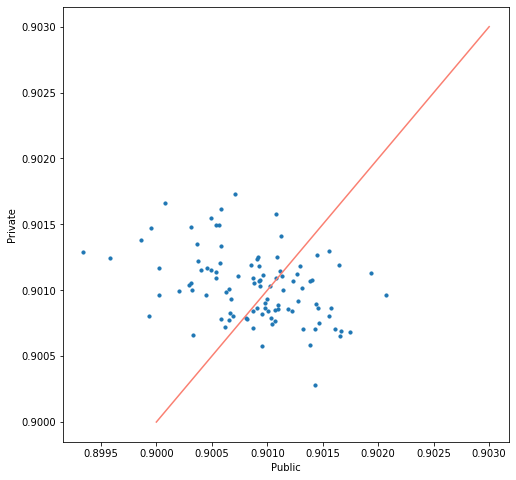

In [226]:
privs = []
pubs = []
for _ in range(100):
    priv_pub = p1_tr["ious"].sample(600000).values
    pub = priv_pub[:150000]
    priv = priv_pub[150000:]
#     print(f'Public {np.mean(pub) :.4f} - Private {np.mean(priv) :.4f}')
    privs.append(np.mean(priv))
    pubs.append(np.mean(pub))

plt.figure(figsize=(8, 8))
plt.scatter(pubs, privs, s=10)
plt.plot([0.9, 0.903], [0.9, 0.903], c="salmon")
plt.xlabel('Public')
plt.ylabel('Private')
plt.show()